In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    RocCurveDisplay, auc, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif

import scipy

def bold_max(df, dataset="", precision=2):
    """
    Return a Styler that bolds the column-wise maxima.

    Works with both:
    - numeric values
    - strings in the format '0.84 ± 0.02'

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with either numeric or 'mean ± std' strings.
    dataset : str
        A caption or title to display above the table.
    precision : int, default 2
        Number of decimals to show if numeric.
    """
    def is_string_with_std(val):
        return isinstance(val, str) and '±' in val

    if df.applymap(is_string_with_std).all().all():
        # All cells are strings with ±
        def highlight_max(col):
            means = col.str.extract(r"(\d+\.\d+) ±")[0].astype(float)
            max_val = means.max()
            return ['font-weight: bold' if v == max_val else '' for v in means]

        return df.style.set_caption(f"Dataset: {dataset}").apply(highlight_max, axis=0)

    else:
        # Assume numeric DataFrame
        return (
            df.style
              .set_caption(f"Dataset: {dataset}")
              .format(f"{{:.{precision}f}}")
              .apply(lambda col: ['font-weight: bold' if v == col.max() else '' for v in col], axis=0)
        )



pd.set_option('display.max_columns', None)

sys.path.append(os.path.abspath("../src"))  

my_analysis_path = '/home/gus/Documents/REPOS/tmt-analysis/data/hand_analysis/2025-05-16_15-31-02/metrics.csv'
metadata_path = '../data/metadata/metadata.csv'
eye_movements_path = '/home/gus/repos/tmt-analysis/src/eye_analysis/eye_movements_metrics.csv'

df = pd.read_csv(my_analysis_path)

In [2]:
df['is_valid'].value_counts(dropna=False)

is_valid
True     1879
False     101
Name: count, dtype: int64

In [3]:
df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()

,subject_id,trial_type,is_valid
0,1,PART_A,10
1,1,PART_B,10
2,2,PART_A,10
3,2,PART_B,9
4,3,PART_A,10
...,...,...,...
193,97,PART_B,10
194,98,PART_A,8
195,98,PART_B,9
196,99,PART_A,10


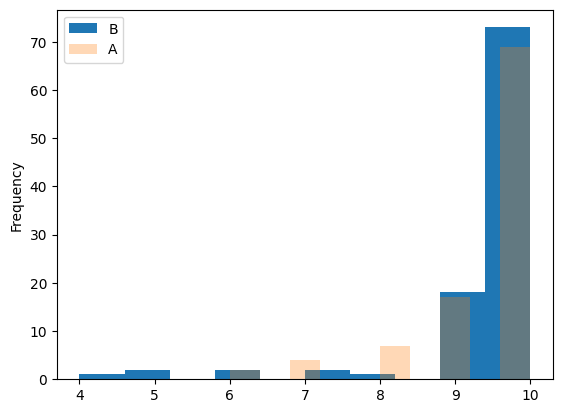

In [4]:
df_grouped = df.groupby(['subject_id', 'trial_type'])['is_valid'].sum().reset_index()
df_grouped[df_grouped['trial_type'] == 'PART_B']['is_valid'].plot(kind="hist")
df_grouped[df_grouped['trial_type'] == 'PART_A']['is_valid'].plot(kind="hist", alpha=0.3)
plt.legend(['B', 'A'])
df_grouped

# Pivot to have PART_A and PART_B sums in separate columns
df_pivot = df_grouped.pivot(index='subject_id', columns='trial_type', values='is_valid').reset_index()
df_pivot.columns = ['subject_id', 'is_valid_sum_A', 'is_valid_sum_B']

df = df.merge(df_pivot, on='subject_id')
df['is_valid_sum_A'] = (df['is_valid_sum_A'] / 10) * 100
df['is_valid_sum_B'] = (df['is_valid_sum_B'] / 10) * 100


In [5]:
def clean_metadata(path_to_metadata):
    df = (
    (
        pd.read_csv(path_to_metadata)
        .rename(
            columns={
                "Anteojos o lentes de contacto": "glasses",
                "Años de escolaridad": "years_of_education",
                "MMSE / 30": "MMSE",
                "Reloj / 3": "clock_drawing_test",
                "Nro de participante": "suj",
                "Género": "sex",
                "Edad": "age",
                "Grupo": "group",
                "TMT A papel PB": "tmt_a_raw",
                "TMT B papel PB": "tmt_b_raw",
                "Digit Symbol pb": "digit_symbol_raw",
                "Span directo pb": "forward_digit_span_raw",
                "span inverso pb": "backward_digit_span_raw",
                "reloj": "clock_drawing_test",
                'TMT A (papel) Z': 'tmt_a_z',
                'TMT B (papel) Z': 'tmt_b_z',
                'Digit - symbol Z': 'digit_symbol_z',
                'Span directo Z': 'forward_digit_span_z',
                'Span inverso z': 'backward_digit_span_z'
            }
        )
        .replace("Caso ?", "Caso")
    )
    .drop([0, 1])
    .reset_index(drop=True) 
    )  # 0 and 1 are summary

    df.columns = [x.lower() for x in df.columns]
    print(df.columns)
    df = df.replace(",", ".", regex=True)
    df["sex"] = df["sex"].replace({"F": 1, "M": 0}).astype("Int64")
    df["group"] = df["group"].str.lower()
    df = df.replace("caso", "mci")
    df = df.replace("Suspendido", 300).replace("No logra", 300)  # 300 seconds it is the max time based on the literature
    df['digit_symbol_raw'] = df['digit_symbol_raw'].replace('no se lo administraron', np.nan).astype(float)
    df['digit_symbol_z'] = df['digit_symbol_z'].replace('pendiente', np.nan).astype(float)
    df = df.astype({"tmt_a_raw": float, "tmt_b_raw": float})
    df["suj"] = df["suj"].astype(int)
    return df

In [6]:
df_metadata_complete = pd.read_csv(metadata_path)
df_metadata_complete.columns
# [col for col in df_metadata_complete.columns if col.endswith(('z', 'Z'))]


Index(['Nro de participante', 'Grupo', 'Clasificación de caso',
       'Comentario (tipo de caso o criterio de exclusión)', 'ID participante',
       'Fecha', 'Hora', 'Neuropsicol.', 'EyeTracker', 'Género', 'Edad',
       'Anteojos o lentes de contacto', 'Observaciones', 'MMSE / 30',
       'MMSE Fallas', 'TMT A papel PB', 'TMT A (papel) Z', 'TMT B papel PB',
       'TMT B papel errores', 'TMT B (papel) Z', 'Digit Symbol pb',
       'Digit - symbol Z', 'Span directo pb', 'Span directo Z',
       'span inverso pb', 'Span inverso z', 'Reloj / 3',
       'Años de escolaridad'],
      dtype='object')

In [7]:
df_metadata = clean_metadata(metadata_path)
df_metadata


Index(['suj', 'group', 'clasificación de caso',
       'comentario (tipo de caso o criterio de exclusión)', 'id participante',
       'fecha', 'hora', 'neuropsicol.', 'eyetracker', 'sex', 'age', 'glasses',
       'observaciones', 'mmse', 'mmse fallas', 'tmt_a_raw', 'tmt_a_z',
       'tmt_b_raw', 'tmt b papel errores', 'tmt_b_z', 'digit_symbol_raw',
       'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
       'backward_digit_span_raw', 'backward_digit_span_z',
       'clock_drawing_test', 'years_of_education'],
      dtype='object')


,suj,group,clasificación de caso,comentario (tipo de caso o criterio de exclusión),id participante,fecha,hora,neuropsicol.,eyetracker,sex,age,glasses,observaciones,mmse,mmse fallas,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt b papel errores,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test,years_of_education
0,1,control,NaN,*,946462,22/1/2024,14:30,Betsabé,Gus,1,52,-,No trajo los lentes para ver de cerca,30.0,--,32.00,0.37,47.00,NaN,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0,18.0
1,2,control,NaN,*,2684844,22/1/2024,15:00,Betsabé,Gus,0,78,Anteojos,NaN,28.0,-2 recuerdo,47.00,0.36,82.00,NaN,0.85,36.0,0.67,6.0,0.07,5.0,0.5,3.0,16.0
2,3,mci,DCL MD no amnesico,NaN,6305,22/1/2024,15:30,Laura,Gus,1,68,Anteojos,NaN,28.0,-2 atención,65.00,-0.38,107.00,NaN,0.40,45.0,0.33,5.0,0.64,4.0,0.21,3.0,12.0
3,4,mci,DCL MD no amnesico,NaN,2060316,22/1/2024,16:00,Laura,Gus,1,80,Anteojos,NaN,28.0,-1 atención. -1 recuerdo,55.00,0.03,109.00,NaN,0.36,38.0,1.33,5.0,-0.64,4.0,-0.21,3.0,15.0
4,5,mci,DCL MD no amnesico,NaN,4744,22/1/2024,16:30,Betsabé,Gus,1,87,Anteojos,NaN,25.0,-2 OT. -1 At. -1 rec. -1VC,63.00,-0.29,180.09,(2 errores),-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,97,mci,DCL no amnesico,NaN,2302423,7/10/2024,13hs,Betsabe,Alejandro,1,75,anteojos,NaN,27.0,1 atenc. 2 recuerdo,38.90,0.69,93.70,2 errores,0.64,28.0,0.00,7.0,1.58,4.0,0.80,3.0,12.0
96,98,mci,DCL no amnesico,NaN,3104154,21/10/2024,13hs,Betsabe,Alejandro,1,70,anteojos,NaN,29.0,1 recuerdo,40.36,-0.63,140.00,4 errores,0.19,46.0,1.00,5.0,-0.08,4.0,0.80,3.0,15.0
97,99,mci,DCL no amnesico,NaN,2486596,21/10/2024,1:15:00 p.m.,Betsabe,Alejandro,1,71,NaN,NaN,29.0,1 recuerdo,51.80,0.16,78.30,NaN,0.92,42.0,0.67,6.0,0.75,6.0,2.80,3.0,18.0
98,100,control,NaN,NaN,22945,11/11/2024,13hs,Betsabe,Alejandro,0,76,anteojos,NaN,29.0,1 VC,50.42,0.22,69.40,-,1.08,40.0,0.67,8.0,2.42,5.0,1.80,3.0,18.0


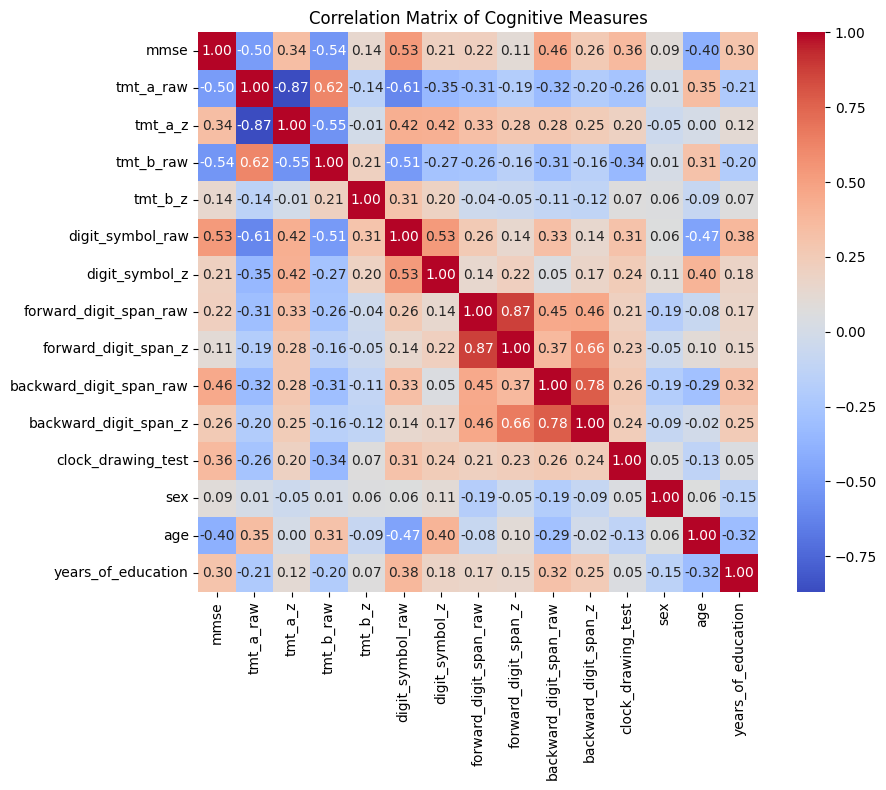

In [8]:
# Clean and convert appropriate columns to numeric
cognitive_columns = ['mmse','tmt_a_raw', 'tmt_a_z',
                    'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
                    'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
                    'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test',]

demographic_colums = ['sex', 'age','years_of_education']

group_column = ['group']

df_metadata_cognitive = df_metadata[['suj','group'] + demographic_colums + cognitive_columns].copy()

df_all = df.merge(df_metadata_cognitive, left_on='subject_id', right_on='suj').rename(columns={"sex_y": "sex", "age_y": "age", "group_y": "group"})
keep_cols = [i for i in df_all.columns if "_x" not in i]
df_all = df_all[keep_cols]

# Compute correlation matrix
corr_matrix = df_metadata[cognitive_columns + demographic_colums].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

In [9]:
demographic_colums

['sex', 'age', 'years_of_education']

In [10]:
df_metadata_cognitive.sort_values('age')

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test
31,32,control,0,25,NaN,29.0,51.70,-2.18,75.00,-0.14,60.0,-1.00,5.0,-1.42,5.0,-0.07,3.0
43,44,control,1,50,18.0,28.0,38.05,-0.17,96.12,-0.38,48.0,-0.67,6.0,-0.17,4.0,-0.6,3.0
72,74,control,1,50,15.0,27.0,28.44,0.68,84.54,0.03,61.0,0.00,7.0,0.79,4.0,-0.21,2.0
36,37,control,1,51,18.0,30.0,40.84,-0.42,74.04,0.40,75.0,0.67,6.0,-0.17,5.0,0.4,3.0
0,1,control,1,52,18.0,30.0,32.00,0.37,47.00,1.36,63.0,0.00,6.0,-0.17,4.0,-0.60,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,56,control,0,86,18.0,28.0,23.29,1.33,51.22,1.41,58.0,2.67,7.0,0.79,5.0,0.5,3.0
45,46,mci,1,86,12.0,28.0,61.26,-0.22,107.41,0.39,32.0,1.33,5.0,-0.64,3.0,-0.93,3.0
4,5,mci,1,87,10.0,25.0,63.00,-0.29,180.09,-0.92,32.0,0.00,5.0,-0.64,3.0,-0.93,1.0
89,91,control,1,90,7.0,27.0,61.78,-0.24,169.00,-0.72,25.0,0.67,5.0,-0.64,4.0,-0.21,3.0


In [11]:
mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
mci[mci['age'] <= 55]

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test
74,76,mci,1,52,15.0,27.0,35.02,0.10,76.34,0.32,57.0,-0.33,6.0,-0.17,5.0,0.40,3.0


In [12]:
min_age = 51

metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_control = metadata_control[metadata_control['age'] >= min_age]
metadata_mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
metadata_mci = metadata_mci[metadata_mci['age'] >= min_age]

for var in demographic_colums:
    if var == "sex":
        # Combine these lists into a 2x2 contingency table
        # Count occurrences of each category (1 = Female, 0 = Male) in each group
        mci_counts = Counter(metadata_mci["sex"])
        control_counts = Counter(metadata_control["sex"])

        # Create the contingency table
        contingency_table = [
            [mci_counts[1], control_counts[1]],  # Female counts  (mci and control)
            [mci_counts[0], control_counts[0]],  # Male counts (mci and control)
        ]
        # Perform Chi-square test
        chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        print(f"chi2: {var}, p={p:.3f}")
        continue
    t_stat, p_value = scipy.stats.ttest_ind(
        metadata_mci[var], metadata_control[var], nan_policy="omit"
    )
    print(f"T-test: {var}, p={p_value:.5f}")


print(len(metadata_control))
print(len(metadata_mci))

chi2: sex, p=0.672
T-test: age, p=0.09681
T-test: years_of_education, p=0.23728
42
55


In [13]:
# metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_mci[metadata_mci['age'] <= 60]

,suj,group,sex,age,years_of_education,mmse,tmt_a_raw,tmt_a_z,tmt_b_raw,tmt_b_z,digit_symbol_raw,digit_symbol_z,forward_digit_span_raw,forward_digit_span_z,backward_digit_span_raw,backward_digit_span_z,clock_drawing_test
53,54,mci,1,57,20.0,30.0,43.00,-0.62,67.00,0.65,56.0,0.33,5.0,-0.64,4.0,-0.21,3.0
54,55,mci,1,60,17.0,28.0,27.00,0.81,92.00,-0.24,45.0,-0.33,5.0,-0.64,4.0,-0.21,3.0
74,76,mci,1,52,15.0,27.0,35.02,0.10,76.34,0.32,57.0,-0.33,6.0,-0.17,5.0,0.40,3.0


<Axes: ylabel='Frequency'>

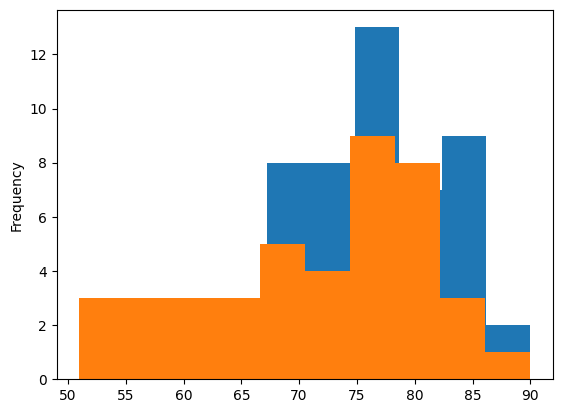

In [14]:
metadata_mci['age'].plot(kind='hist')
metadata_control['age'].plot(kind='hist')

In [224]:
min_age = 51
df = df_all.copy()

df_valid = df[df["is_valid"]]

# df_valid = df_valid[df_valid['age'] >= min_age]

valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

# subjects_with_enough_valid_trials = valid_counts[
#     (valid_counts.get('PART_A', 0) >= 2) & (valid_counts.get('PART_B', 0) >= 2)
# ].index

# df_valid = df_valid[df_valid['subject_id'].isin(subjects_with_enough_valid_trials)]

subjects_final_set = list(df_valid['subject_id'].unique())

digital_tmt_vars = [
       'speed_threshold', 'total_distance', 'rt',
       'correct_targets_touches', 'wrong_targets_touches', 'mean_speed',
       'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
       'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
       'peak_abs_acceleration', 'mean_negative_acceleration',
       'std_negative_acceleration', 'peak_negative_acceleration',
       'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
       'travel_distance', 'search_distance', 'hesitation_avg_speed',
       'travel_avg_speed', 'search_avg_speed', 'state_transitions',
       'hesitation_ratio', 'total_hesitations', 'average_duration',
       'max_duration','zigzag_amplitude', 'distance_difference_from_ideal', 
       'area_difference_from_ideal',
]

non_digital_vars = ['mmse', 'tmt_a_raw','tmt_a_z', 'tmt_b_raw', 'tmt_b_z', 
                    'digit_symbol_raw', 'digit_symbol_z','forward_digit_span_raw', 
                    'forward_digit_span_z', 'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test']


df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]


df_digital_tmt = df_valid.pivot_table(index='subject_id', columns="trial_type", values=digital_tmt_vars)

df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]
# Identify all PART_A and PART_B columns
part_a_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_A')]
part_b_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_B')]

# Match variables by stripping suffixes
common_vars = [col.replace('_PART_A', '') for col in part_a_cols if col.replace('_PART_A', '_PART_B') in part_b_cols]

# Compute B/A ratios
for var in common_vars:
    a_col = f"{var}_PART_A"
    b_col = f"{var}_PART_B"
    ratio_col = f"{var}_B_A_ratio"
    df_digital_tmt[ratio_col] = df_digital_tmt[b_col] / df_digital_tmt[a_col]

df_digital_tmt = df_digital_tmt.reset_index(names='suj')
df_digital_tmt = df_digital_tmt[df_digital_tmt['suj'].isin(subjects_final_set)]
df_digital_tmt_with_target = df_digital_tmt.merge(df_metadata_cognitive[['suj'] + ['group']], on='suj').set_index('suj')
df_digital_tmt_with_target['group'] = df_digital_tmt_with_target['group'].str.replace('mci', '1').replace('control', '0').astype(int)


demographic_df = df_metadata_cognitive[['suj', 'sex', 'age', 'years_of_education','group']].copy()
demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
demographic_df = demographic_df[demographic_df['suj'].isin(subjects_final_set)].set_index('suj')

non_digital_df = df_metadata_cognitive[['suj'] + non_digital_vars + ['group']].copy()
non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
non_digital_df = non_digital_df[non_digital_df['suj'].isin(subjects_final_set)].set_index('suj')

# Eye movements
df_eye = pd.read_csv(eye_movements_path)
# df_eye = df_eye[[col for col in df_eye.columns if 'mean' not in col]]

df_digital_hand_and_eye = df_digital_tmt_with_target.merge(df_eye, on='suj').drop(['group_y'],axis=1).set_index('suj')
df_digital_hand_and_eye['group'] = df_digital_hand_and_eye['group_x']
df_digital_hand_and_eye = df_digital_hand_and_eye.drop('group_x',axis=1)


# Check
print(df_digital_tmt_with_target['group'].value_counts())
print(demographic_df['group'].value_counts())
print(non_digital_df['group'].value_counts())
print(df_digital_hand_and_eye['group'].value_counts())

only_part_b = False
print("only_part_b:", only_part_b)

if only_part_b:
    df_digital_tmt_with_target = df_digital_tmt_with_target[[col for col in df_digital_tmt_with_target.columns if col.endswith(('B','b'))] + ['group']]
    df_digital_hand_and_eye = df_digital_hand_and_eye[[col for col in df_digital_hand_and_eye.columns if col.endswith(('B','b'))] + ['group']] 

group
1    55
0    43
Name: count, dtype: int64
group
1    55
0    43
Name: count, dtype: int64
group
1    55
0    43
Name: count, dtype: int64
group
1    34
0    32
Name: count, dtype: int64
only_part_b: False


[('average_duration_PART_B', 'average_duration_PART_A'), ('distance_difference_from_ideal_PART_A', 'area_difference_from_ideal_PART_A'), ('hesitation_distance_PART_B', 'hesitation_distance_PART_A'), ('hesitation_ratio_PART_A', 'correct_targets_touches_PART_A'), ('hesitation_ratio_PART_B', 'hesitation_ratio_PART_A'), ('hesitation_time_PART_A', 'correct_targets_touches_PART_A'), ('hesitation_time_PART_A', 'hesitation_ratio_PART_A'), ('hesitation_time_PART_B', 'correct_targets_touches_PART_B'), ('hesitation_time_PART_B', 'hesitation_ratio_PART_B'), ('hesitation_time_PART_B', 'hesitation_time_PART_A'), ('max_duration_PART_A', 'average_duration_PART_A'), ('max_duration_PART_A', 'hesitation_ratio_PART_A'), ('max_duration_PART_A', 'hesitation_time_PART_A'), ('max_duration_PART_B', 'average_duration_PART_B'), ('max_duration_PART_B', 'hesitation_ratio_PART_B'), ('max_duration_PART_B', 'hesitation_time_PART_B'), ('mean_abs_acceleration_PART_B', 'hesitation_avg_speed_PART_B'), ('mean_abs_accelera

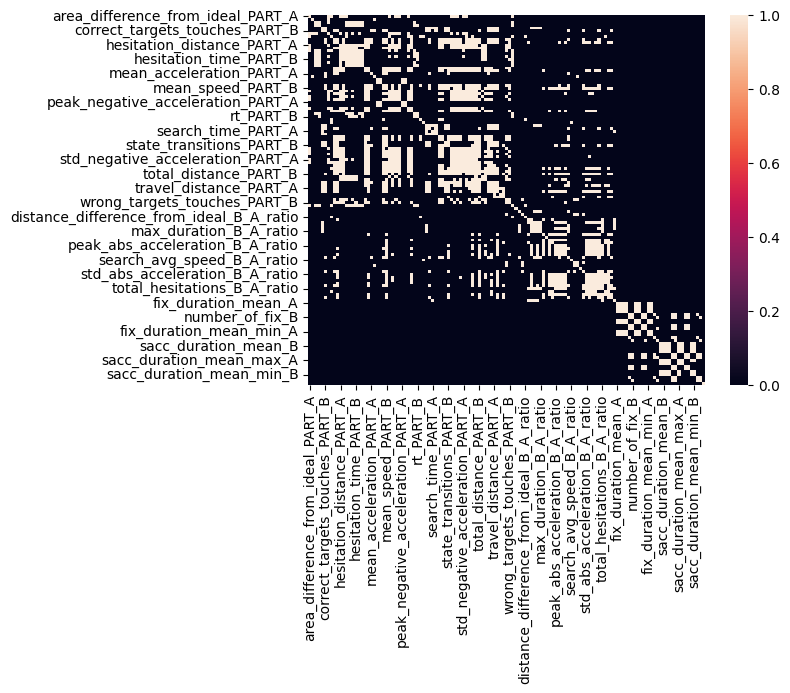

In [238]:
sns.heatmap(df_digital_hand_and_eye.corr() > 0.4)

# Compute correlation matrix
corr_matrix = df_digital_hand_and_eye.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature pairs with correlation > 0.4
high_corr_pairs = [(col1, col2) for col1 in upper.columns for col2 in upper.index if upper.loc[col2, col1] > 0.8]

# Display result
print(high_corr_pairs)


In [94]:
[col for col in df_digital_tmt_with_target.columns if 'hesitation' in col][-2:]
[col for col in df_digital_tmt_with_target.columns]

['area_difference_from_ideal_PART_A',
 'area_difference_from_ideal_PART_B',
 'average_duration_PART_A',
 'average_duration_PART_B',
 'correct_targets_touches_PART_A',
 'correct_targets_touches_PART_B',
 'distance_difference_from_ideal_PART_A',
 'distance_difference_from_ideal_PART_B',
 'hesitation_avg_speed_PART_A',
 'hesitation_avg_speed_PART_B',
 'hesitation_distance_PART_A',
 'hesitation_distance_PART_B',
 'hesitation_ratio_PART_A',
 'hesitation_ratio_PART_B',
 'hesitation_time_PART_A',
 'hesitation_time_PART_B',
 'max_duration_PART_A',
 'max_duration_PART_B',
 'mean_abs_acceleration_PART_A',
 'mean_abs_acceleration_PART_B',
 'mean_acceleration_PART_A',
 'mean_acceleration_PART_B',
 'mean_negative_acceleration_PART_A',
 'mean_negative_acceleration_PART_B',
 'mean_speed_PART_A',
 'mean_speed_PART_B',
 'peak_abs_acceleration_PART_A',
 'peak_abs_acceleration_PART_B',
 'peak_acceleration_PART_A',
 'peak_acceleration_PART_B',
 'peak_negative_acceleration_PART_A',
 'peak_negative_accelera

dataset: hand_and_eye
Class distribution: {0: 32, 1: 34}
n_importances: 15

🧪 Nested CV for: RandomForestClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔍 Feature importances for RandomForestClassifier (using permutation importance):
1. number_of_fix_min_B: 0.0083
2. hesitation_time_PART_A: 0.0083
3. search_avg_speed_PART_A: 0.0076
4. state_transitions_PART_A: 0.0049
5. std_abs_acceleration_PART_A: 0.0028
6. std_speed_PART_A: 0.0028
7. peak_acceleration_PART_B: 0.0028
8. search_avg_speed_PART_B: 0.0021
9. number_of_fix_A: 0.0021
10. travel_time_PART_B: 0.0014
11. zigzag_amplitude_PART_B: 0.0014
12. std_negative_acceleration_PART_A: 0.0007
13. mean_speed_PART_A: 0.0007
14. peak_acceleration_PART_A: 0.0007
15. search_distance_PART_A: 0.0000
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits


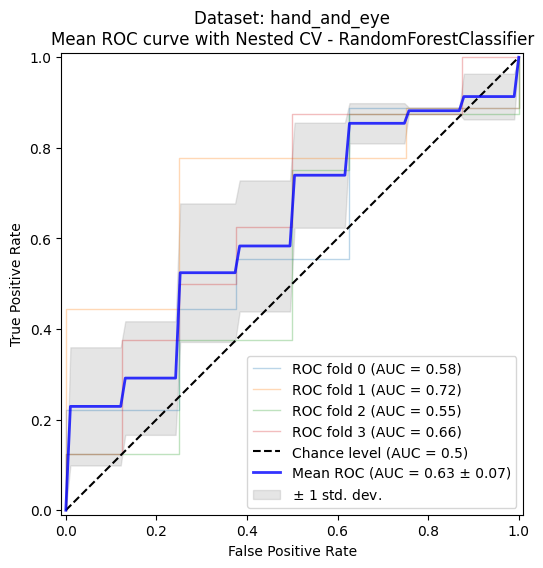

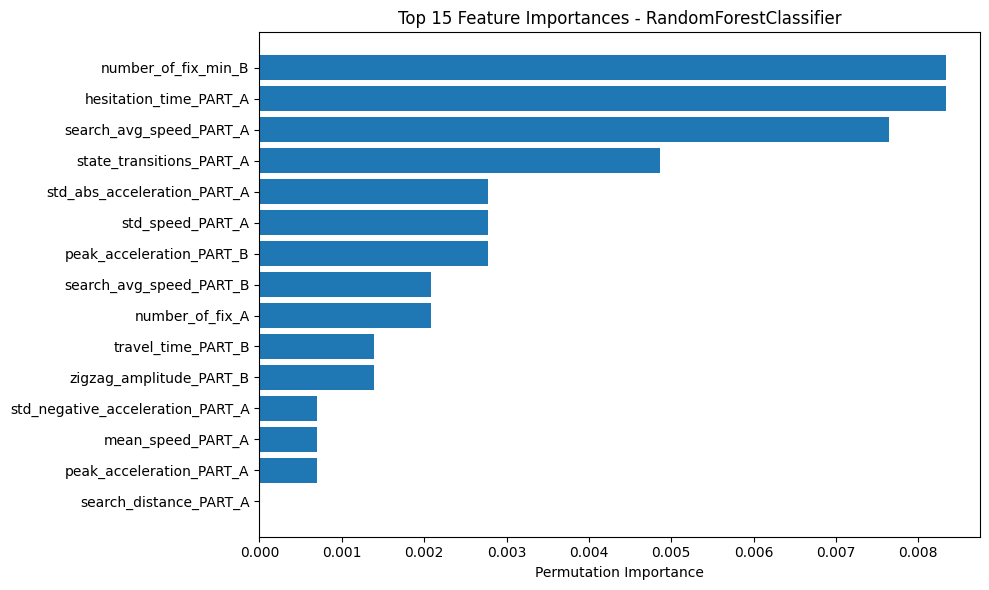

🔧 Best hyperparameters across folds for RandomForestClassifier:
  Fold 0: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
  Fold 1: {'classifier__max_depth': None, 'classifier__n_estimators': 500}
  Fold 2: {'classifier__max_depth': None, 'classifier__n_estimators': 1000}
  Fold 3: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
🔢 Global Confusion Matrix (all folds combined):
[[19 13]
 [15 19]]

🧪 Nested CV for: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits

🔍 Feature importances for SVC (using permutation importance):
1. area_difference_from_ideal_PART_B: 0.0583
2. number_of_fix_A: 0.0444
3. number_of_sacc_A: 0.0361
4. total_hesitations_PART_B: 0.0347
5. hesitation_time_PART_B: 0.0278
6. peak_negative_acceleration_PART_B: 0.0264
7. number_of_fix_min_A: 0.0236
8. std_negative_acceleration_PART_B: 0.0236
9. wrong_targets_touches_PART_B: 0.0208
10. peak_abs_acceleration_PART_B: 0.0167
11. peak_speed_PART_B: 0.0097
12. hesitation_avg_spe

<Figure size 600x500 with 0 Axes>

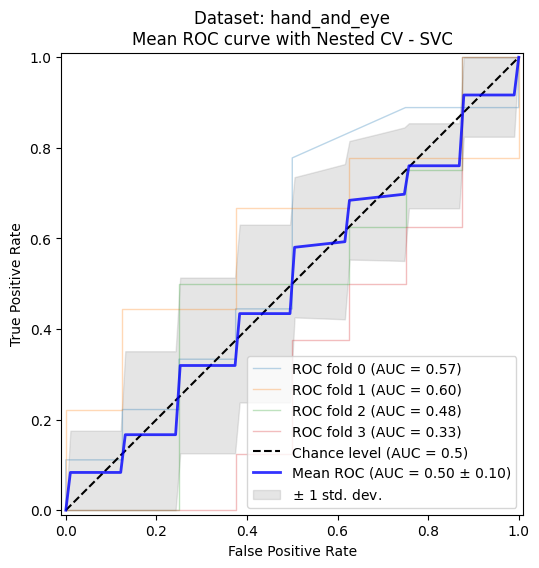

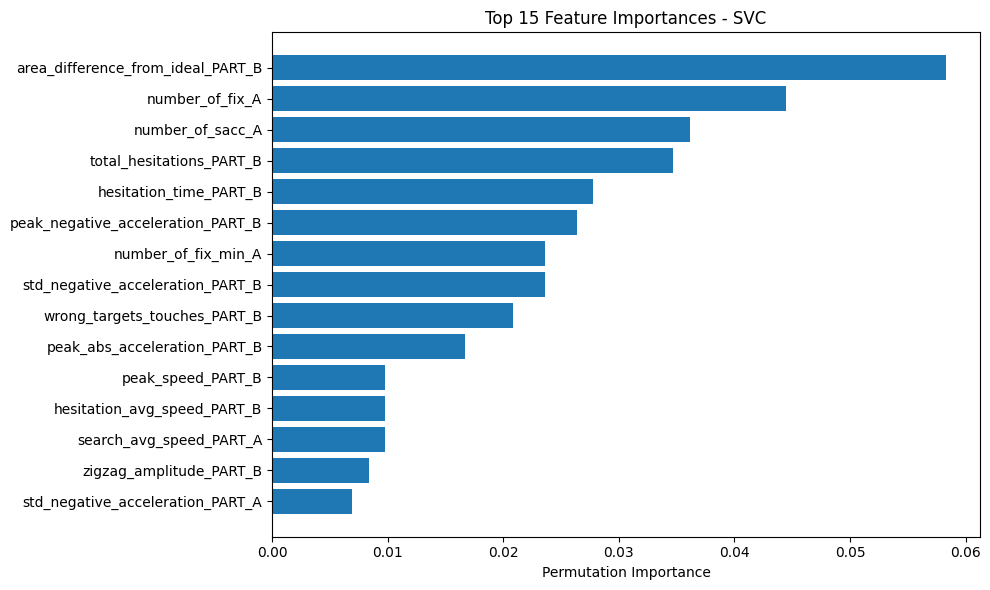

🔧 Best hyperparameters across folds for SVC:
  Fold 0: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
  Fold 1: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
  Fold 2: {'classifier__C': 1, 'classifier__kernel': 'linear'}
  Fold 3: {'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
🔢 Global Confusion Matrix (all folds combined):
[[12 20]
 [ 8 26]]

🧪 Nested CV for: LogisticRegression
Fitting 3 folds for each of 3 candidates, totalling 9 fits

🔍 Feature importances for LogisticRegression (using permutation importance):
1. search_avg_speed_PART_A: 0.0514
2. area_difference_from_ideal_PART_B: 0.0514
3. number_of_sacc_A: 0.0167
4. search_avg_speed_PART_B: 0.0167
5. number_of_fix_A: 0.0111
6. number_of_sacc_max_B: 0.0111
7. hesitation_time_PART_B: 0.0097
8. std_negative_acceleration_PART_B: 0.0069
9. number_of_fix_min_B: 0.0069
10. number_of_sacc_min_A: 0.0042
11. distance_difference_from_ideal_PART_A: 0.0028
12. mean_speed_PART_B: 0.0028
13. search_distance_PART_A: 0.0028


<Figure size 600x500 with 0 Axes>

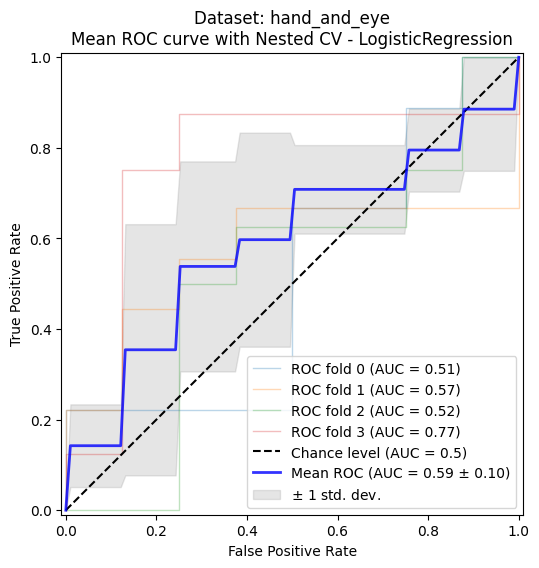

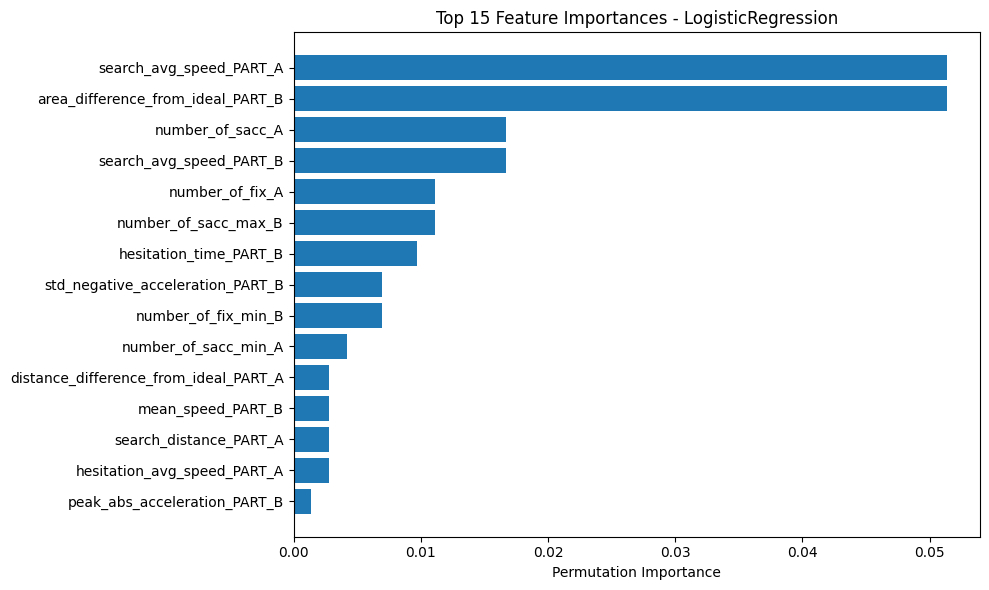

🔧 Best hyperparameters across folds for LogisticRegression:
  Fold 0: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
  Fold 1: {'classifier__C': 10, 'classifier__penalty': 'l2'}
  Fold 2: {'classifier__C': 10, 'classifier__penalty': 'l2'}
  Fold 3: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
🔢 Global Confusion Matrix (all folds combined):
[[21 11]
 [18 16]]

🏆 Model Performance Comparison:

ACCURACY:
  LogisticRegression: 0.560 ± 0.042
  RandomForestClassifier: 0.574 ± 0.091
  SVC: 0.574 ± 0.061

BALANCED_ACCURACY:
  LogisticRegression: 0.559 ± 0.041
  RandomForestClassifier: 0.571 ± 0.091
  SVC: 0.569 ± 0.057

PRECISION:
  LogisticRegression: 0.574 ± 0.054
  RandomForestClassifier: 0.603 ± 0.096
  SVC: 0.573 ± 0.056

RECALL:
  LogisticRegression: 0.462 ± 0.235
  RandomForestClassifier: 0.549 ± 0.229
  SVC: 0.764 ± 0.205

F1:
  LogisticRegression: 0.488 ± 0.196
  RandomForestClassifier: 0.550 ± 0.158
  SVC: 0.642 ± 0.074

AUC:
  LogisticRegression: 0.591 ± 0.119
  RandomFo

<Figure size 600x500 with 0 Axes>

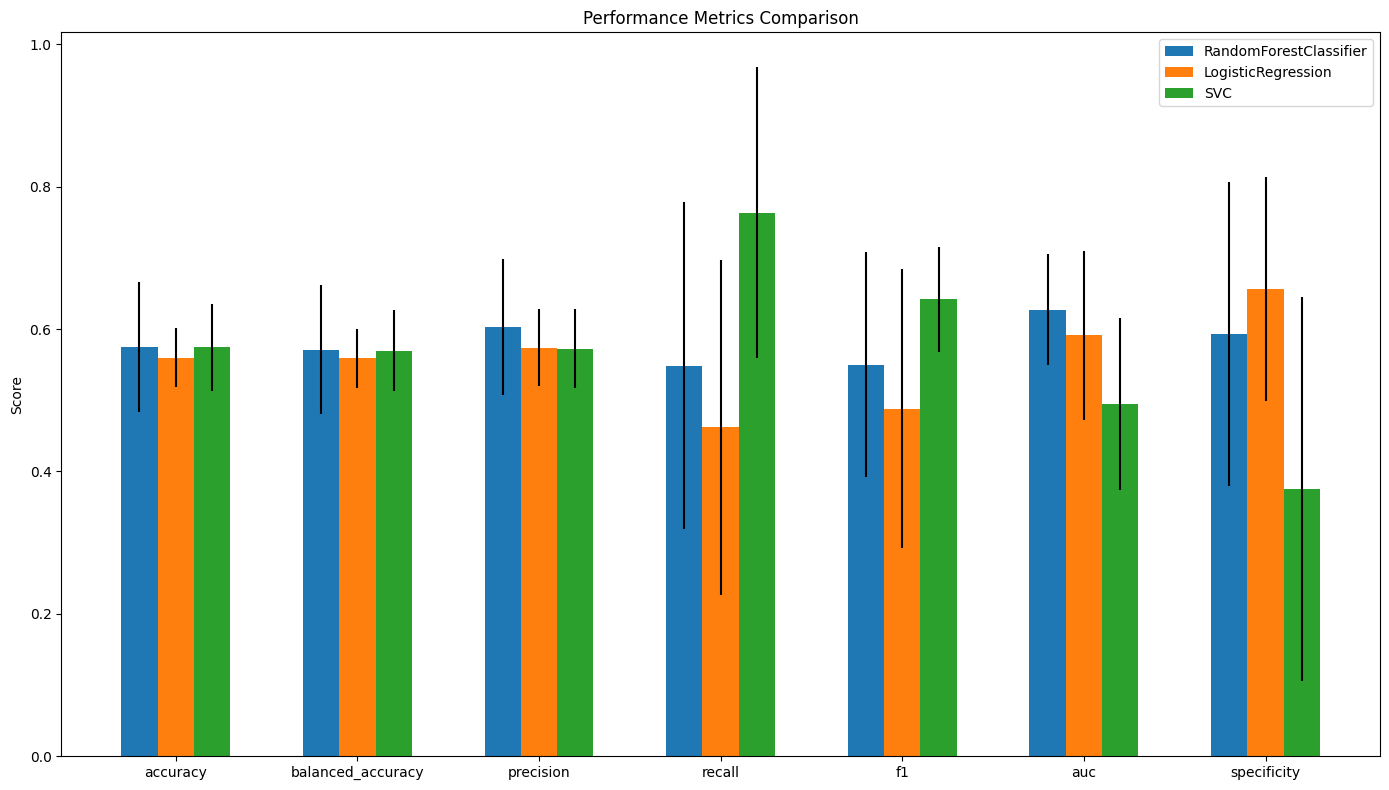

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.56,0.56,0.57,0.46,0.49,0.59,0.66
RandomForestClassifier,0.57,0.57,0.60,0.55,0.55,0.63,0.59
SVC,0.57,0.57,0.57,0.76,0.64,0.49,0.38


In [ ]:
dataset = 'hand_and_eye'
print('dataset:', dataset)

# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case 'digital_test_less_subjects': # less subjects
        X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
        y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
    case 'hand_and_eye':
        X = df_digital_hand_and_eye.iloc[:, :-1].values
        y = df_digital_hand_and_eye.iloc[:, -1].values
        feature_names = df_digital_hand_and_eye.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye` o `digital_test_less_subjects`]')

n_importances = 15

# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
print("n_importances:", n_importances)

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        # "feature_selection__n_features_to_select": [10, 15, 20],   
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    # xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=41)
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])


# Perform nested CV for each model
for model in models:
    fig, ax = plt.subplots(figsize=(6, 6))
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    importances_added = False  # Prevents printing for every fold

    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    
    # Reset feature importance counts for this model
    feature_importance_counts = {name: 0 for name in feature_names}
    
    # Metrics for this model
    fold_metrics = []
    
    
    all_y_true = []
    all_y_pred = []

    best_models = []
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            # ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
            #                          n_features_to_select=n_importances)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        
        # Use AUC as the primary scoring metric for optimization
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1  # Show progress
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        best_models.append(best_model)

        # print("Best n_features_to_select:",
        #       grid.best_params_["feature_selection__n_features_to_select"])
    

        # Compute and plot feature importances for all models using permutation importance
        if not importances_added:
            print(f"\n🔍 Feature importances for {model_name} (using permutation importance):")

            # Permutation importance works with any fitted estimator
            result = permutation_importance(
                best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
            )
            sorted_idx = result.importances_mean.argsort()[::-1][:n_importances]
            top_feature_names = np.array(feature_names)[sorted_idx]
            top_importances = result.importances_mean[sorted_idx]

            # Print importances
            for i, (name, imp) in enumerate(zip(top_feature_names, top_importances), 1):
                print(f"{i}. {name}: {imp:.4f}")

            # Plot
            fig1, ax1 = plt.subplots(figsize=(10, 6))
            ax1.barh(range(len(top_importances)), top_importances[::-1], align='center')
            ax1.set_yticks(range(len(top_importances)), top_feature_names[::-1])
            ax1.set_xlabel("Permutation Importance")
            ax1.set_title(f"Top {n_importances} Feature Importances - {model_name}")
            plt.tight_layout()
            # plt.show()

            importances_added = True  # Only print once per model

      
        # # Track selected features
        # feature_selector = best_model.named_steps['feature_selection']
        # selected_mask = feature_selector.support_
        # fold_selected_features = feature_names[selected_mask]
        # selected_features.append(fold_selected_features)
        
        # # Update feature importance counts
        # for feature in fold_selected_features:
        #     feature_importance_counts[feature] += 1
        
        # Generate ROC curve
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
        )
        
        # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        
        # Interpolate TPR for mean ROC
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    
    # Calculate mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot mean ROC
    ax.plot(mean_fpr, mean_tpr, color="b",
            label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
            lw=2, alpha=0.8)
    
    std_tpr = np.std(tprs, axis=0)
    ax.fill_between(mean_fpr,
                    np.maximum(mean_tpr - std_tpr, 0),
                    np.minimum(mean_tpr + std_tpr, 1),
                    color="grey", alpha=0.2,
                    label=r"$\pm$ 1 std. dev.")
    
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
           title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
    ax.legend(loc="lower right")
    plt.show()
    
    # Print best params from each fold
    print(f"🔧 Best hyperparameters across folds for {model_name}:")
    for i, params in enumerate(best_params_list):
        print(f"  Fold {i}: {params}")
    

    # Calculate and print mean metrics across folds
    model_metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = model_metrics_df.mean(numeric_only=True)
    std_metrics = model_metrics_df.std(numeric_only=True)
    
    # Plot confusion matrix (average across folds)
    plt.figure(figsize=(6, 5))
    cm_df = pd.DataFrame(fold_metrics)[['fold', 'model']].copy()
    cm_df['TP'] = 0
    cm_df['FP'] = 0
    cm_df['TN'] = 0
    cm_df['FN'] = 0
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_test = X[test_idx]
        y_test = y[test_idx]
        best_model = grid.best_estimator_  # Using the last trained model
        y_pred = best_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cm_df.loc[fold, ['TP', 'FP', 'TN', 'FN']] = [tp, fp, tn, fn]

    
    # avg_cm = np.array([
    #     [cm_df['TN'].mean(), cm_df['FP'].mean()],
    #     [cm_df['FN'].mean(), cm_df['TP'].mean()]
    # ])
    
    # sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues',
    #             xticklabels=['Negative', 'Positive'],
    #             yticklabels=['Negative', 'Positive'])
    # plt.title(f'Average Confusion Matrix - {model_name}')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()

    global_cm = confusion_matrix(all_y_true, all_y_pred)

    ## Optional: print the matrix
    print("🔢 Global Confusion Matrix (all folds combined):")
    print(global_cm)

    # Optional: plot the matrix
    # ConfusionMatrixDisplay(global_cm, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
    # plt.title(f'Global Confusion Matrix - {model_name}')
    # plt.show()
    
    # Plot feature importances for RandomForestClassifier
    # if model_name == "RandomForestClassifier":
    #     # For RandomForest, we can get feature importances directly
    #     # We'll use the feature importances from the last fold's best model
    #     best_model = grid.best_estimator_
        
    #     # # Get the feature selector to identify which features were selected
    #     # feature_selector = best_model.named_steps['feature_selection']
    #     # selected_mask = feature_selector.support_
        
    #     # Get the RandomForest classifier from the pipeline
    #     rf_classifier = best_model.named_steps['classifier']
        
    #     # Get importances for the selected features
    #     importances = rf_classifier.feature_importances_
        
    #     # Get names of the selected features
    #     # selected_feature_names = feature_names[selected_mask]
        
    #     # Sort features by importance
    #     indices = np.argsort(importances)[::-1]
        
    #     # Take top N features
    #     top_indices = indices[:n_importances]
        
    #     # Get corresponding names and importance values
    #     # top_features = selected_feature_names[top_indices]
    #     top_importances = importances[top_indices]
        
    #     # Plot
    #     fig2, ax2 = plt.subplots(figsize=(10, 6))
    #     ax2.barh(range(len(top_indices)), top_importances[::-1], align='center')
    #     ax2.set_yticks(range(len(top_indices)))
    #     ax2.set_yticklabels(feature_names[top_indices])
    #     ax2.set_xlabel("Feature Importance")
    #     ax2.set_title(f"Top {n_importances} Feature Importances - {model_name}")
    #     plt.tight_layout()
    #     plt.show()

# Compare metrics across models
print("\n🏆 Model Performance Comparison:")
metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

# Print formatted comparison
for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']:
    print(f"\n{metric.upper()}:")
    for model_name in metrics_comparison.index:
        print(f"  {model_name}: {metrics_comparison.loc[model_name, metric]:.3f} ± "
              f"{metrics_std.loc[model_name, metric]:.3f}")

# Create a visual comparison of models across metrics
plt.figure(figsize=(14, 8))

metrics_to_plot = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'auc', 'specificity']
x = np.arange(len(metrics_to_plot))
width = 0.2
n_models = len(models)
offsets = np.linspace(-(width * (n_models-1))/2, (width * (n_models-1))/2, n_models)

for i, model_name in enumerate(metrics_comparison.sort_values('auc', ascending=False).index):
    heights = [metrics_comparison.loc[model_name, m] for m in metrics_to_plot]
    errors = [metrics_std.loc[model_name, m] for m in metrics_to_plot]
    plt.bar(x + offsets[i], heights, width, yerr=errors, label=model_name)

plt.xticks(x, metrics_to_plot)
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.legend()
plt.tight_layout()
plt.show()


bold_max(metrics_comparison)
#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

metrics_comparison_str
bold_max(metrics_comparison_str, dataset=dataset)

In [ ]:
# ───────────────────────────────────────────────────────────────
# 0. SET-UP GENERAL (igual que antes)
# ───────────────────────────────────────────────────────────────
dataset = 'hand_and_eye'
importances_added = False
print('dataset:', dataset)

# Selección del dataset
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case 'digital_test_less_subjects': # less subjects
        X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
        y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
    case 'hand_and_eye':
        X = df_digital_hand_and_eye.iloc[:, :-1].values
        y = df_digital_hand_and_eye.iloc[:, -1].values
        feature_names = df_digital_hand_and_eye.columns[:-1]
    case _:
        raise ValueError('please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye` o `digital_test_less_subjects`]')

# ───────────────────────────────────────────────────────────────
# 1. DEFINICIÓN DE PARÁMETROS Y MODELOS (igual que antes)
# ───────────────────────────────────────────────────────────────
n_importances = 15
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ['l2']
    },
    "XGBClassifier": {
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, random_state=42),
    xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# ───────────────────────────────────────────────────────────────
# 2. NUEVA VALIDACIÓN CRUZADA 4×10
# ───────────────────────────────────────────────────────────────

outer_cv = RepeatedStratifiedKFold(
    n_splits=4,
    n_repeats=10,         ### <<< CAMBIO ➊: 10 repeticiones
    random_state=0        ### <<< CAMBIO ➋: semilla global reproducible
)

mean_fpr = np.linspace(0, 1, 100)
all_metrics_df = pd.DataFrame(columns=[
    'model', 'repeat', 'fold',     ### <<< CAMBIO ➌: añadimos repeat
    'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])

# ───────────────────────────────────────────────────────────────
# 3. BUCLE EXTERNO (40 iteraciones: 4 folds × 5 repeticiones)
# ───────────────────────────────────────────────────────────────
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested 4x10 CV for: {model_name}")

    tprs, aucs, best_params_list, fold_metrics = [], [], [], []
    feature_importance_counts = {n: 0 for n in feature_names}

    # fig, ax = plt.subplots(figsize=(6, 6))
    all_y_true, all_y_pred = [], []

    # Enumeramos 'repeat' y 'fold' para guardar en métricas
    for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        repeat = outer_idx // 4          ### <<< CAMBIO ➍: índice de repetición
        fold   = outer_idx % 4           ### <<< CAMBIO ➎: fold dentro de la repetición

        # ── Split
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # ── Inner CV: estratificado 3-fold con la MISMA semilla por repetición
        seed = repeat  
        print('inner_cv seed:', seed)
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(LogisticRegression(max_iter=1000),
                                      n_features_to_select=n_importances)),
            ('classifier', model)
        ])

        # Hiperparámetros
        param_grid = param_grids.get(model_name, {})

        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=inner_cv,               ### <<< CAMBIO ➏: inner CV estratificado
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        
        





        # ── Predicción
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        # ── Métricas
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)

        fold_metrics.append({
            'model': model_name,
            'repeat': repeat,          ### <<< CAMBIO ➐
            'fold': fold,              ### <<< CAMBIO ➑
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        })

        # ── ROC por fold
        viz = RocCurveDisplay.from_predictions(
            y_test, y_pred_proba,
            name=f"R{repeat}-F{fold}", alpha=0.3, lw=1, ax=ax,
            plot_chance_level=False
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # ── Guardamos métricas
    all_metrics_df = pd.concat([all_metrics_df,
                                pd.DataFrame(fold_metrics)],
                               ignore_index=True)

    # ── ROC promedio (igual que antes) …
    # ── Confusion matrix global, plots, importancia de features, etc. …
    #      (sin cambios respecto a tu versión original)
    # …

# ───────────────────────────────────────────────────────────────
# 4. RESUMEN FINAL (igual que antes)
# ───────────────────────────────────────────────────────────────

metrics_comparison = (all_metrics_df
                      .groupby('model')
                      .mean(numeric_only=True))
metrics_std = (all_metrics_df
               .groupby('model')
               .std(numeric_only=True))
# …
# all_metrics_df.to_csvf(f'notebooks/results/modelling/all_metrics_{dataset}_nested4x10CV.csv',index=False)
bold_max(metrics_comparison)


dataset: hand_and_eye
Class distribution: {0: 32, 1: 34}

🧪 Nested 4x10 CV for: RandomForestClassifier
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 3
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 4
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 5
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 6
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 7
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 8
inner_cv seed: 9
inner_cv seed: 9
inner_cv seed: 9
inner_cv seed: 9

🧪 Nested 4x10 CV for: SVC
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 0
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 1
inner_cv seed: 2
inner_cv seed: 2
inner_cv seed: 2
inn

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.57,0.57,0.58,0.59,0.57,0.61,0.54
RandomForestClassifier,0.53,0.53,0.54,0.55,0.54,0.57,0.51
SVC,0.53,0.53,0.54,0.66,0.57,0.54,0.40
XGBClassifier,0.56,0.56,0.58,0.57,0.56,0.56,0.55


In [231]:
best_model

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('feature_selection',
                 RFE(estimator=LogisticRegression(max_iter=1000),
                     n_features_to_select=15)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enabl...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Pruebas

dataset: hand_and_eye
n_importances: 15
Class distribution: {0: 32, 1: 34}
n_importances: 15

🧪 Nested CV for: RandomForestClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔍 Feature importances for RandomForestClassifier (using permutation importance):
1. travel_avg_speed_PART_A: 0.0410
2. std_speed_B_A_ratio: 0.0333
3. distance_difference_from_ideal_B_A_ratio: 0.0146
4. search_distance_PART_B: 0.0132
5. average_duration_B_A_ratio: 0.0083
6. state_transitions_B_A_ratio: 0.0049
7. total_hesitations_B_A_ratio: 0.0028
8. total_distance_PART_B: 0.0000
9. speed_threshold_PART_B: 0.0000
10. peak_speed_PART_B: 0.0000
11. rt_PART_A: 0.0000
12. rt_PART_B: 0.0000
13. travel_avg_speed_PART_B: 0.0000
14. search_avg_speed_PART_B: 0.0000
15. search_distance_PART_A: 0.0000
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits

🧪 Nested CV for: SVC
Fi

,accuracy,balanced_accuracy,precision,recall,f1,auc,specificity
model,,,,,,,
LogisticRegression,0.577 ± 0.11,0.576 ± 0.12,0.622 ± 0.14,0.622 ± 0.13,0.602 ± 0.05,0.569 ± 0.13,0.531 ± 0.31
RandomForestClassifier,0.593 ± 0.15,0.595 ± 0.15,0.642 ± 0.16,0.597 ± 0.25,0.583 ± 0.19,0.612 ± 0.12,0.594 ± 0.33
SVC,0.515 ± 0.02,0.516 ± 0.02,0.536 ± 0.05,0.750 ± 0.32,0.590 ± 0.11,0.548 ± 0.17,0.281 ± 0.36


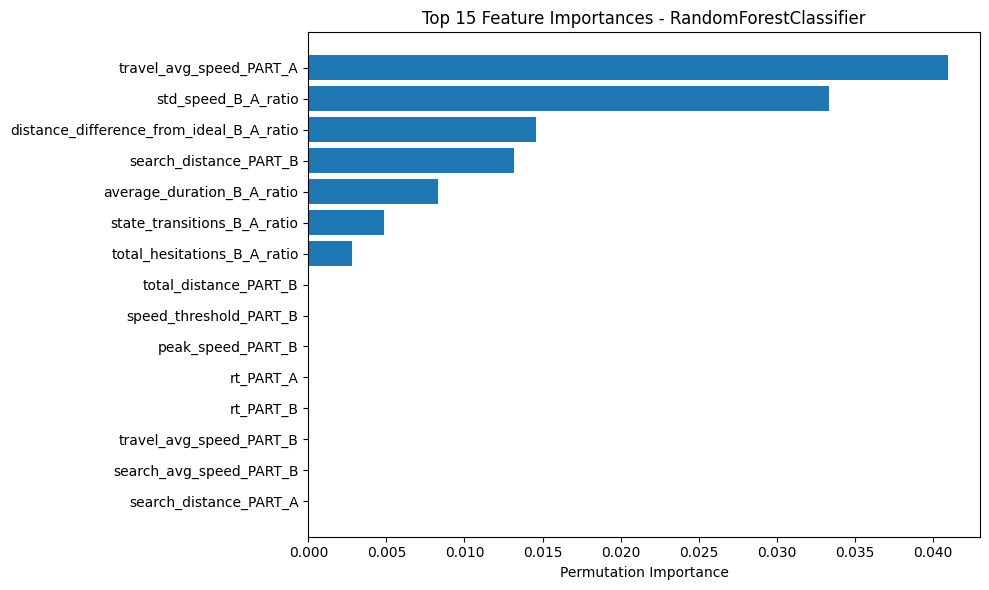

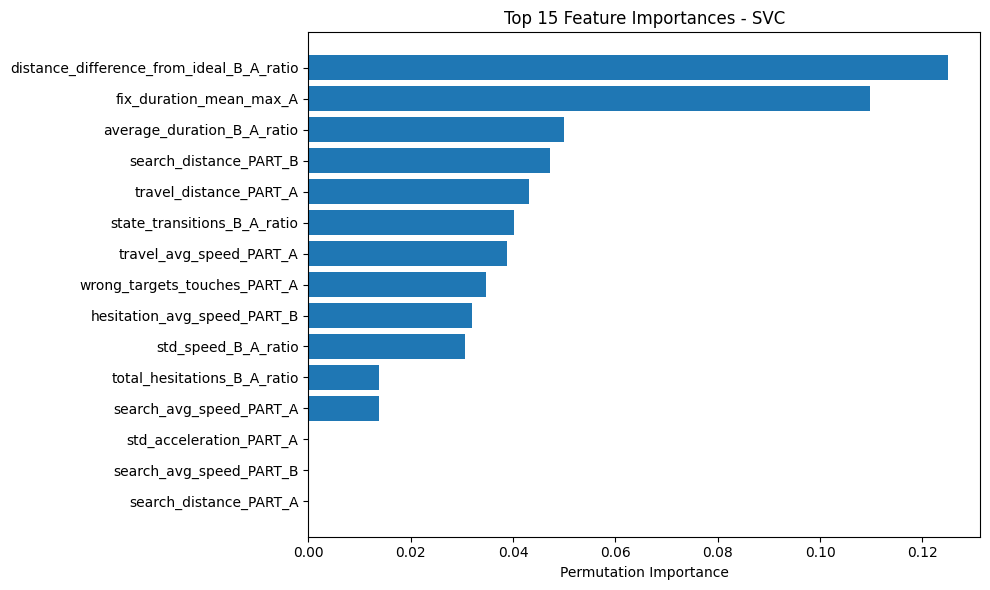

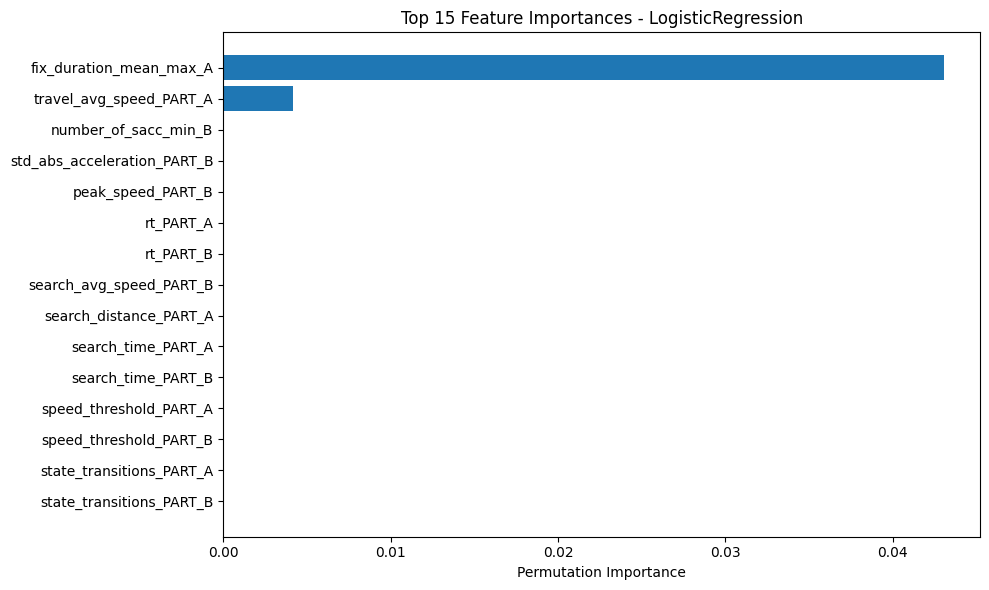

In [228]:
dataset = 'hand_and_eye'
n_importances = 15
plot_roc = False
plot_confusion_matrix = False
print('dataset:', dataset)
print("n_importances:", n_importances)


# Assuming df_digital_tmt_with_target is already defined
match dataset:
    case 'demographic':
        X = demographic_df.iloc[:, :-1].values
        y = demographic_df.iloc[:, -1].values
        feature_names = demographic_df.columns[:-1]
    case 'non_digital_tests':
        X = non_digital_df.iloc[:, :-1].values
        y = non_digital_df.iloc[:, -1].values
        feature_names = non_digital_df.columns[:-1]
    case 'digital_test':
        X = df_digital_tmt_with_target.iloc[:, :-1].values
        y = df_digital_tmt_with_target.iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.columns[:-1]
    case 'digital_test_less_subjects': 
        X = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, :-1].values
        y = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].iloc[:, -1].values
        feature_names = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index].columns[:-1]
    case 'hand_and_eye':
        X = df_digital_hand_and_eye.iloc[:, :-1].values 
        y = df_digital_hand_and_eye.iloc[:, -1].values
        feature_names = df_digital_hand_and_eye.columns[:-1]
    case 'eye_only':
        df_only_eye = df_digital_hand_and_eye[[col for col in df_digital_hand_and_eye.columns if 'fix' in col or 'sacc' in col] + ['group']]
        X = df_only_eye.iloc[:, :-1].values
        y = df_only_eye.iloc[:, -1].values
        feature_names = df_only_eye.columns[:-1]
    case _:
        raise ValueError(
            'please select a valid dataset [`demographic`, `non_digital_tests`, `digital_test`,`df_digital_hand_and_eye`, `eye_only` or `digital_test_less_subjects`]'
            )

# Print class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))
print("n_importances:", n_importances)

# Define parameter grids
param_grids = {
    "RandomForestClassifier": {
        "classifier__n_estimators": [100, 500, 700, 1000],
        "classifier__max_depth": [None, 10, 20, 30]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ['linear', 'rbf']
    },
    "LogisticRegression": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l1", "l2"],
    },
    "XGBClassifier": {
        # "feature_selection__n_features_to_select": [10, 15, 20],
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 5],
        "classifier__learning_rate": [0.05, 0.1]
    }
}

# Define models to evaluate
models = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    # xgb.XGBClassifier(random_state=42, tree_method="hist", eval_metric='logloss')
]

# Set up outer CV
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=49) # LO CAMBIEEEEEEEEE!!!!!!!!!!!!!
mean_fpr = np.linspace(0, 1, 100)

# Create a DataFrame to store all metrics for all models
all_metrics_df = pd.DataFrame(columns=[
    'model', 'fold', 'accuracy', 'balanced_accuracy', 'precision', 
    'recall', 'f1', 'auc', 'specificity'
])


# Perform nested CV for each model
for model in models:
    model_name = model.__class__.__name__
    print(f"\n🧪 Nested CV for: {model_name}")
    importances_added = False  # Prevents printing for every fold

    
    # Results for this model
    tprs = []
    aucs = []
    best_params_list = []
    selected_features = []
    
    # Reset feature importance counts for this model
    feature_importance_counts = {name: 0 for name in feature_names}
    
    # Metrics for this model
    fold_metrics = []
    
    
    all_y_true = []
    all_y_pred = []

    best_models = []
    # Outer CV loop
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('feature_selection', RFE(estimator=LogisticRegression(max_iter=1000), 
                                     n_features_to_select=n_importances)),
            ('classifier', model)
        ])
        
        # Set up grid search with inner CV
        param_grid = param_grids.get(model_name, {})
        
        # Use AUC as the primary scoring metric for optimization
        grid = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=3,  # inner CV
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1  # Show progress
        )
        
        # Train on the current fold
        grid.fit(X_train, y_train)
        
        # Store best parameters
        best_params_list.append(grid.best_params_)
        
        # Get the best model from GridSearchCV
        best_model = grid.best_estimator_
        best_models.append(best_model)

        # Compute and plot feature importances for all models using permutation importance
        if not importances_added:
            print(f"\n🔍 Feature importances for {model_name} (using permutation importance):")

            # Permutation importance works with any fitted estimator
            result = permutation_importance(
                best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring="roc_auc"
            )
            sorted_idx = result.importances_mean.argsort()[::-1][:n_importances]
            top_feature_names = np.array(feature_names)[sorted_idx]
            top_importances = result.importances_mean[sorted_idx]

            # Print importances
            for i, (name, imp) in enumerate(zip(top_feature_names, top_importances), 1):
                print(f"{i}. {name}: {imp:.4f}")

            # Plot
            fig1, ax1 = plt.subplots(figsize=(10, 6))
            ax1.barh(range(len(top_importances)), top_importances[::-1], align='center')
            ax1.set_yticks(range(len(top_importances)), top_feature_names[::-1])
            ax1.set_xlabel("Permutation Importance")
            ax1.set_title(f"Top {n_importances} Feature Importances - {model_name}")
            plt.tight_layout()
            # plt.show()

            importances_added = True  # Only print once per model
        
        # Get predicted probabilities and classes
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_pred = best_model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        # Calculate various metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        metrics = {
            'model': model_name,
            'fold': fold,
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'specificity': specificity
        }
        
        fold_metrics.append(metrics)
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
    
        if plot_roc:
            fig, ax = plt.subplots(figsize=(6, 6))
            # Generate ROC curve
            viz = RocCurveDisplay.from_estimator(
                best_model,
                X_test,
                y_test,
                name=f"ROC fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == outer_cv.get_n_splits() - 1),
            )        
            
            # Interpolate TPR for mean ROC
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)
    if plot_roc:
        # Calculate mean ROC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)       
        # Plot mean ROC
        ax.plot(mean_fpr, mean_tpr, color="b",
                label=f"Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})",
                lw=2, alpha=0.8)
        
        std_tpr = np.std(tprs, axis=0)
        ax.fill_between(mean_fpr,
                        np.maximum(mean_tpr - std_tpr, 0),
                        np.minimum(mean_tpr + std_tpr, 1),
                        color="grey", alpha=0.2,
                        label=r"$\pm$ 1 std. dev.")
        
        ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate",
            title=f"Dataset: {dataset}\nMean ROC curve with Nested CV - {model_name}")
        ax.legend(loc="lower right")
        plt.show()
    

    # Calculate and print mean metrics across folds
    model_metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = model_metrics_df.mean(numeric_only=True)
    std_metrics = model_metrics_df.std(numeric_only=True)
    
# Compare metrics across models
metrics_comparison = all_metrics_df.groupby('model').mean(numeric_only=True)
metrics_std = all_metrics_df.groupby('model').std(numeric_only=True)

#  Create new DataFrame with formatted strings
metrics_comparison_str = pd.DataFrame(index=metrics_comparison.index)

for metric in metrics_to_plot:
    means = metrics_comparison[metric]
    stds = metrics_std[metric]
    metrics_comparison_str[metric] = [
        f"{mean:.3f} ± {std:.2f}" for mean, std in zip(means, stds)
    ]

bold_max(metrics_comparison_str, dataset=dataset)

In [217]:
df_digital_hand_and_eye[list(df_digital_tmt_with_target.columns[:-1]) + ['number_of_sacc_A'] + ['group']]

,area_difference_from_ideal_PART_A,area_difference_from_ideal_PART_B,average_duration_PART_A,average_duration_PART_B,correct_targets_touches_PART_A,correct_targets_touches_PART_B,distance_difference_from_ideal_PART_A,distance_difference_from_ideal_PART_B,hesitation_avg_speed_PART_A,hesitation_avg_speed_PART_B,hesitation_distance_PART_A,hesitation_distance_PART_B,hesitation_ratio_PART_A,hesitation_ratio_PART_B,hesitation_time_PART_A,hesitation_time_PART_B,max_duration_PART_A,max_duration_PART_B,mean_abs_acceleration_PART_A,mean_abs_acceleration_PART_B,mean_acceleration_PART_A,mean_acceleration_PART_B,mean_negative_acceleration_PART_A,mean_negative_acceleration_PART_B,mean_speed_PART_A,mean_speed_PART_B,peak_abs_acceleration_PART_A,peak_abs_acceleration_PART_B,peak_acceleration_PART_A,peak_acceleration_PART_B,peak_negative_acceleration_PART_A,peak_negative_acceleration_PART_B,peak_speed_PART_A,peak_speed_PART_B,rt_PART_A,rt_PART_B,search_avg_speed_PART_A,search_avg_speed_PART_B,search_distance_PART_A,search_distance_PART_B,search_time_PART_A,search_time_PART_B,speed_threshold_PART_A,speed_threshold_PART_B,state_transitions_PART_A,state_transitions_PART_B,std_abs_acceleration_PART_A,std_abs_acceleration_PART_B,std_acceleration_PART_A,std_acceleration_PART_B,std_negative_acceleration_PART_A,std_negative_acceleration_PART_B,std_speed_PART_A,std_speed_PART_B,total_distance_PART_A,total_distance_PART_B,total_hesitations_PART_A,total_hesitations_PART_B,travel_avg_speed_PART_A,travel_avg_speed_PART_B,travel_distance_PART_A,travel_distance_PART_B,travel_time_PART_A,travel_time_PART_B,wrong_targets_touches_PART_A,wrong_targets_touches_PART_B,zigzag_amplitude_PART_B,area_difference_from_ideal_B_A_ratio,average_duration_B_A_ratio,correct_targets_touches_B_A_ratio,distance_difference_from_ideal_B_A_ratio,hesitation_avg_speed_B_A_ratio,hesitation_distance_B_A_ratio,hesitation_ratio_B_A_ratio,hesitation_time_B_A_ratio,max_duration_B_A_ratio,mean_abs_acceleration_B_A_ratio,mean_acceleration_B_A_ratio,mean_negative_acceleration_B_A_ratio,mean_speed_B_A_ratio,peak_abs_acceleration_B_A_ratio,peak_acceleration_B_A_ratio,peak_negative_acceleration_B_A_ratio,peak_speed_B_A_ratio,rt_B_A_ratio,search_avg_speed_B_A_ratio,search_distance_B_A_ratio,search_time_B_A_ratio,speed_threshold_B_A_ratio,state_transitions_B_A_ratio,std_abs_acceleration_B_A_ratio,std_acceleration_B_A_ratio,std_negative_acceleration_B_A_ratio,std_speed_B_A_ratio,total_distance_B_A_ratio,total_hesitations_B_A_ratio,travel_avg_speed_B_A_ratio,travel_distance_B_A_ratio,travel_time_B_A_ratio,wrong_targets_touches_B_A_ratio,number_of_sacc_A,group
suj,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,0.004309,0.004641,0.385317,0.832404,12.100000,11.500000,0.053798,0.068700,0.221629,0.120955,0.404075,0.341054,0.233823,0.365433,1.880910,3.153832,0.872165,1.746753,2.887850,2.025144,0.025524,-0.027891,-4.095468,-3.576737,0.211050,0.155287,47.848607,38.862292,47.440821,35.077518,-37.516094,-36.039206,2.443123,1.965225,22939.600000,25017.100000,0.105245,0.075936,1.073316,1.036071,10.590629,13.738224,0.157889,0.157889,30.400000,27.300000,5.149999,4.067202,5.913155,4.548789,5.140858,4.651588,0.320057,0.264442,3.790343,3.412193,4.700000,4.200000,0.402126,0.399456,2.312952,2.035068,5.788363,5.073949,3.100000,4.100000,2.023339,1.077184,2.160308,0.950413,1.277000,0.545756,0.844037,1.562861,1.676758,2.002777,0.701264,-1.092745,0.873340,0.735782,0.812193,0.739395,0.960633,0.804391,1.090564,0.721512,0.965299,1.297206,1.0,0.898026,0.789748,0.769266,0.904827,0.826235,0.900233,0.893617,0.993361,0.879857,0.876578,1.322581,39.000000,1
4,0.010872,0.008507,0.773556,1.859370,2.888889,3.250000,0.146933,0.173550,0.252331,0.166556,2.473458,2.668425,0.673204,0.850067,9.919365,16.290851,2.503792,5.347980,3.346226,2.527158,0.027682,-0.008153,-3.927048,-3.569324,0.277021,0.182410,41.532974,50.604258,37.689157,47.371710,-34.113745,-43.162017,2.242401,2.816160,18835

In [214]:
df_digital_hand_and_eye[[col for col in df_digital_hand_and_eye.columns if 'fix' in col or 'sacc' in col] + ['group']]['number_of_sacc_A']

suj
3     39.000000
4     35.600000
5     56.571429
6     24.000000
7     53.750000
        ...    
93    40.900000
94    66.444444
95    58.400000
97    56.100000
99    54.900000
Name: number_of_sacc_A, Length: 66, dtype: float64

In [223]:
df_hand_only =  df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index]
eye_cols = list(set(df_digital_hand_and_eye.columns) - set(df_hand_only.columns))
eye_cols

['number_of_sacc_min_B',
 'number_of_fix_A',
 'number_of_fix_max_A',
 'number_of_sacc_max_A',
 'number_of_sacc_A']

In [225]:
eye_cols = [col for col in df_digital_hand_and_eye.columns if 'fix' in col or 'sacc' in col]

['fix_duration_mean_A',
 'fix_duration_mean_B',
 'fix_duration_median_A',
 'fix_duration_median_B',
 'number_of_fix_A',
 'number_of_fix_B',
 'fix_duration_mean_max_A',
 'fix_duration_mean_max_B',
 'number_of_fix_max_A',
 'number_of_fix_max_B',
 'fix_duration_mean_min_A',
 'fix_duration_mean_min_B',
 'number_of_fix_min_A',
 'number_of_fix_min_B',
 'sacc_duration_mean_A',
 'sacc_duration_mean_B',
 'sacc_duration_median_A',
 'sacc_duration_median_B',
 'number_of_sacc_A',
 'number_of_sacc_B',
 'sacc_duration_mean_max_A',
 'sacc_duration_mean_max_B',
 'number_of_sacc_max_A',
 'number_of_sacc_max_B',
 'sacc_duration_mean_min_A',
 'sacc_duration_mean_min_B',
 'number_of_sacc_min_A',
 'number_of_sacc_min_B']

In [195]:
eye_cols = df_digital_hand_and_eye

selector = SelectKBest(score_func=f_classif, k=5)
X_eye_selected = selector.fit_transform(df_digital_hand_and_eye[eye_cols], df_digital_hand_and_eye['group'])
selected_names = np.array(eye_cols)[selector.get_support()]
print(selected_names)

['peak_abs_acceleration_PART_B' 'peak_speed_PART_B'
 'search_avg_speed_PART_A' 'std_speed_PART_B' 'group']


/home/gus/Documents/enviroments/feedback/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [108 141] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/gus/Documents/enviroments/feedback/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/gus/Documents/enviroments/feedback/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [185]:
keeped_eye_cols = ['number_of_sacc_min_B', 'number_of_fix_A', 'number_of_fix_max_A',
                   'number_of_sacc_max_A', 'number_of_sacc_A']

hand_cols = [col for col in df_digital_hand_and_eye.columns if 'fix' not in col or 'sacc' not in col]
df_digital_hand_and_eye[keeped_eye_cols + hand_cols]

,number_of_sacc_min_B,number_of_fix_A,number_of_fix_max_A,number_of_sacc_max_A,number_of_sacc_A,area_difference_from_ideal_PART_A,area_difference_from_ideal_PART_B,average_duration_PART_A,average_duration_PART_B,correct_targets_touches_PART_A,correct_targets_touches_PART_B,distance_difference_from_ideal_PART_A,distance_difference_from_ideal_PART_B,hesitation_avg_speed_PART_A,hesitation_avg_speed_PART_B,hesitation_distance_PART_A,hesitation_distance_PART_B,hesitation_ratio_PART_A,hesitation_ratio_PART_B,hesitation_time_PART_A,hesitation_time_PART_B,max_duration_PART_A,max_duration_PART_B,mean_abs_acceleration_PART_A,mean_abs_acceleration_PART_B,mean_acceleration_PART_A,mean_acceleration_PART_B,mean_negative_acceleration_PART_A,mean_negative_acceleration_PART_B,mean_speed_PART_A,mean_speed_PART_B,peak_abs_acceleration_PART_A,peak_abs_acceleration_PART_B,peak_acceleration_PART_A,peak_acceleration_PART_B,peak_negative_acceleration_PART_A,peak_negative_acceleration_PART_B,peak_speed_PART_A,peak_speed_PART_B,rt_PART_A,rt_PART_B,search_avg_speed_PART_A,search_avg_speed_PART_B,search_distance_PART_A,search_distance_PART_B,search_time_PART_A,search_time_PART_B,speed_threshold_PART_A,speed_threshold_PART_B,state_transitions_PART_A,state_transitions_PART_B,std_abs_acceleration_PART_A,std_abs_acceleration_PART_B,std_acceleration_PART_A,std_acceleration_PART_B,std_negative_acceleration_PART_A,std_negative_acceleration_PART_B,std_speed_PART_A,std_speed_PART_B,total_distance_PART_A,total_distance_PART_B,total_hesitations_PART_A,total_hesitations_PART_B,travel_avg_speed_PART_A,travel_avg_speed_PART_B,travel_distance_PART_A,travel_distance_PART_B,travel_time_PART_A,travel_time_PART_B,wrong_targets_touches_PART_A,wrong_targets_touches_PART_B,zigzag_amplitude_PART_B,area_difference_from_ideal_B_A_ratio,average_duration_B_A_ratio,correct_targets_touches_B_A_ratio,distance_difference_from_ideal_B_A_ratio,hesitation_avg_speed_B_A_ratio,hesitation_distance_B_A_ratio,hesitation_ratio_B_A_ratio,hesitation_time_B_A_ratio,max_duration_B_A_ratio,mean_abs_acceleration_B_A_ratio,mean_acceleration_B_A_ratio,mean_negative_acceleration_B_A_ratio,mean_speed_B_A_ratio,peak_abs_acceleration_B_A_ratio,peak_acceleration_B_A_ratio,peak_negative_acceleration_B_A_ratio,peak_speed_B_A_ratio,rt_B_A_ratio,search_avg_speed_B_A_ratio,search_distance_B_A_ratio,search_time_B_A_ratio,speed_threshold_B_A_ratio,state_transitions_B_A_ratio,std_abs_acceleration_B_A_ratio,std_acceleration_B_A_ratio,std_negative_acceleration_B_A_ratio,std_speed_B_A_ratio,total_distance_B_A_ratio,total_hesitations_B_A_ratio,travel_avg_speed_B_A_ratio,travel_distance_B_A_ratio,travel_time_B_A_ratio,wrong_targets_touches_B_A_ratio,fix_duration_median_A,fix_duration_median_B,number_of_fix_A,number_of_fix_B,number_of_fix_max_A,number_of_fix_max_B,number_of_fix_min_A,number_of_fix_min_B,sacc_duration_median_A,sacc_duration_median_B,number_of_sacc_A,number_of_sacc_B,number_of_sacc_max_A,number_of_sacc_max_B,number_of_sacc_min_A,number_of_sacc_min_B,group
suj,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,40,33.800000,44,46,39.000000,0.004309,0.004641,0.385317,0.832404,12.100000,11.500000,0.053798,0.068700,0.221629,0.120955,0.404075,0.341054,0.233823,0.365433,1.880910,3.153832,0.872165,1.746753,2.887850,2.025144,0.025524,-0.027891,-4.095468,-3.576737,0.211050,0.155287,47.848607,38.862292,47.440821,35.077518,-37.516094,-36.039206,2.443123,1.965225,22939.600000,25017.100000,0.105245,0.075936,1.073316,1.036071,10.590629,13.738224,0.157889,0.157889,30.400000,27.300000,5.149999,4.067202,5.913155,4.548789,5.140858,4.651588,0.320057,0.264442,3.790343,3.412193,4.700000,4.200000,0.402126,0.399456,2.312952,2.035068,5.788363,5.073949,3.100000,4.100000,2.023339,1.077184,2.160308,0.950413,1.277000,0.545756,0.844037,1.562861,1.676758,2.002777,0.701264,-1.092745,0.873340,0.735782,0.812193,0.739395,0.960633,0.804391,1.090564,0.721512,0.965299,1.